In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import date, timedelta


repo_root = Path().resolve().parent
sys.path.append(str(repo_root))

In [2]:
from vnstock import Listing, Quote
list = Listing(source='vci')
VN30 = list.symbols_by_group('VN30').tolist()
tickers = ['ACB','VPB', 'TPB']
day_range = 365
#tickers = ['ACB', 'VIC', 'HPG']
end = (date.today()).isoformat()
start = (date.today() - timedelta(days=day_range)).isoformat()



In [3]:
import src.fetch_info as fetch

raw = fetch.fetch_stock(tickers=tickers,interval='1d',hist=day_range, combine=False)
raw

Fetching ACB...
Done!

Fetching VPB...
Done!

Fetching TPB...
Done!



{'ACB':           time   open   high    low  close   volume
 0   2024-12-11  21.18  21.31  21.05  21.22  8832805
 1   2024-12-12  21.22  21.31  21.10  21.14  5867353
 2   2024-12-13  21.14  21.14  20.97  21.01  6044475
 3   2024-12-16  21.01  21.10  20.93  21.01  5165719
 4   2024-12-17  21.10  21.10  20.93  21.05  3331723
 ..         ...    ...    ...    ...    ...      ...
 259 2025-12-25  24.30  24.60  24.00  24.00  7250600
 260 2025-12-26  23.90  24.05  23.65  23.90  7831900
 261 2025-12-29  23.85  24.10  23.80  24.00  3770400
 262 2025-12-30  24.00  24.20  23.90  24.10  5337300
 263 2025-12-31  24.15  24.25  23.90  24.00  5932900
 
 [264 rows x 6 columns],
 'VPB':           time   open   high    low  close    volume
 0   2024-12-11  18.74  18.79  18.55  18.74  13264710
 1   2024-12-12  18.74  19.03  18.64  18.79  23037081
 2   2024-12-13  18.69  18.79  18.59  18.64   7752312
 3   2024-12-16  18.64  18.69  18.50  18.59   6793885
 4   2024-12-17  18.59  18.64  18.45  18.45   8188602

In [4]:
for i in raw:
    stock = raw[i]
    stock['ret'] = np.log(stock['close'] / stock['close'].shift(1)) 
    stock.dropna(subset=['ret'], inplace=True)
    stock['ticker'] = i
    print(stock.isna().sum().sum())


0
0
0


In [5]:
df = []
for i in raw:
    df.append(raw[i])
df = pd.concat(df)
df['mvol'] = df['close'] * df['volume']
df = df[['time','ticker','close', 'mvol', 'ret']]
df

,time,ticker,close,mvol,ret
1,2024-12-12,ACB,21.14,1.240358e+08,-0.003777
2,2024-12-13,ACB,21.01,1.269944e+08,-0.006168
3,2024-12-16,ACB,21.01,1.085318e+08,0.000000
4,2024-12-17,ACB,21.05,7.013277e+07,0.001902
5,2024-12-18,ACB,21.01,7.112173e+07,-0.001902
...,...,...,...,...,...
259,2025-12-25,TPB,17.00,1.067345e+08,-0.023257
260,2025-12-26,TPB,16.95,1.263606e+08,-0.002946
261,2025-12-29,TPB,16.90,8.429382e+07,-0.002954
262,2025-12-30,TPB,17.15,1.574747e+08,0.014685


In [6]:
from IPython.display import clear_output   
import src.mpt as mpt

sims = 4000

result = mpt.mpt_sim(df, sims)

result

Index(['ACB', 'TPB', 'VPB'], dtype='object', name='ticker')


,Return,Volatility,Weight
1140,0.001603,0.023767,"{'ACB': 0.0014218283288579244, 'TPB': 0.009905..."
1271,0.001603,0.023767,"{'ACB': 0.0009405452824604671, 'TPB': 0.010628..."
2022,0.001597,0.023687,"{'ACB': 0.01188253263614176, 'TPB': 0.00353788..."
426,0.001575,0.023470,"{'ACB': 0.022601564907567512, 'TPB': 0.0133234..."
1025,0.001572,0.023418,"{'ACB': 0.031794227853271816, 'TPB': 0.0055109..."
...,...,...,...
27,0.000483,0.015721,"{'ACB': 0.9208700155872168, 'TPB': 0.077023418..."
352,0.000477,0.015693,"{'ACB': 0.9728176406267675, 'TPB': 0.022567903..."
2750,0.000477,0.015694,"{'ACB': 0.9626986156953625, 'TPB': 0.034773395..."
1454,0.000476,0.015692,"{'ACB': 0.9766323514348852, 'TPB': 0.018793034..."


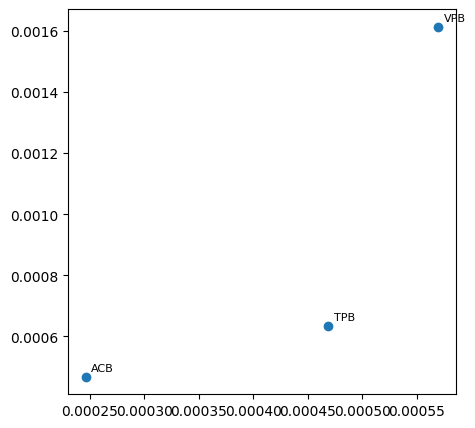

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
aggregate = df.groupby('ticker')['ret'].agg(['mean', 'std','var'])  

plt.figure(figsize=(5,5))
plt.scatter(aggregate['var'], aggregate['mean'])

for x, y, label in zip(aggregate['var'], aggregate['mean'], aggregate.index):
    plt.annotate(label, (x, y), xytext=(4, 4), textcoords="offset points", fontsize=8)



In [8]:
W = pd.DataFrame(result["Weight"].to_list(), index=result.index).add_prefix("w_")
result2 = pd.concat([result.drop(columns=["Weight"]), W], axis=1)
fin = result2.sort_values(['Return', 'Volatility'], ascending=[False, True])
fin


,Return,Volatility,w_ACB,w_TPB,w_VPB
1140,0.001603,0.023767,0.001422,0.009906,0.988672
1271,0.001603,0.023767,0.000941,0.010628,0.988431
2022,0.001597,0.023687,0.011883,0.003538,0.984580
426,0.001575,0.023470,0.022602,0.013323,0.964075
1025,0.001572,0.023418,0.031794,0.005511,0.962695
...,...,...,...,...,...
27,0.000483,0.015721,0.920870,0.077023,0.002107
352,0.000477,0.015693,0.972818,0.022568,0.004614
2750,0.000477,0.015694,0.962699,0.034773,0.002528
1454,0.000476,0.015692,0.976632,0.018793,0.004575


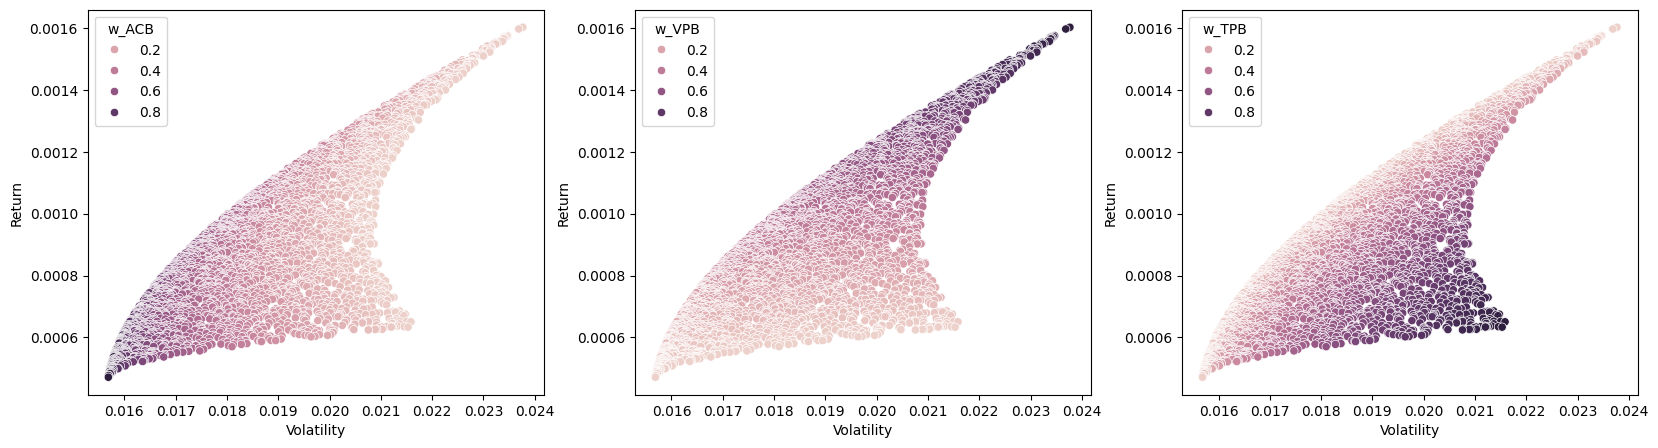

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(tickers), figsize=(20, 5), sharex=False, sharey=False)


for i in range(len(tickers)):
    sns.scatterplot(x=fin['Volatility'], y=fin['Return'], hue=fin[f'w_{tickers[i]}'], ax=axs[i])
